# Projeto 4 – Classificação de lesões de substância branca no Lúpus

Project: White matter lesion classification for Systemic Lupus Erythematosus

# Apresentação 

O presente projeto foi originado para satisfazer a atividade de participação P4 da disciplina de pós-graduação Ciência e Visualização de Dados em Saúde, oferecida no primeiro semestre de 2022, na Unicamp.


O trabalho foi realizado pelo grupo (Tabela 1):

Nome                | RA      | Especialização
--------------------|---------|---------------
Emilia Oliveira     | 262867  | Saúde
Gabriel Garcia      | 216179  | Computação
Robert Tartarotti   | 157173  | Elétrica

<center><b>Tabela 1: participantes</b></center>



# Introdução
O objetivo deste trabalho é utilizar técnicas de Machine Learning para descobrir se a partir de imagens de lesões causadas por Acidente Vascular Cerebral (AVC) ou Esclerose Múltipla (EM) é possível criar um modelo capaz de descobrir qual a etiologia das lesões do Lúpus e prever se uma lesão é AVC, EM ou SLE.

## Ferramentas
As ferramentas utilizadas para alcançar os objetivos do projeto foram:

* Google Colab Notebooks
* Python 3
* Estatística
* Support Vector Machines (SVM)

## Preparo e uso dos dados

A seleção e tratamento dos dados foi feita seguindo as seguintes etapas:
* Foi feita uma selação das imagens que seriam usadas, imagens que não possuíssem máscaras, não tinham doença, portanto foram descartadas.
* Leitura e conversão das imagens em um formato que possa ser lido e operado pelo Python, uma matriz Numpy.
* Obtenção dos descritores de histograma:
 - Mínimo
 - Máximo
 - Média
 - Variância
 - Skewness
 - Kurtosis Fisher
 - Kurtosis Pearson
 - Desvio Padrão
 - Mediana
 - Moda
* Obtenção de descritores de textura:
 - SRE - Short Run Emphasis
 - LRE - Long Run Emphasis
 - GLU - Grey Level Uniformity
 - RLU - Run Length Uniformity
 - RPC - Run Percentage
 - GLCM - Gray Level Co-occurrence Matriz
* Obtenção de descritores estatísticos da matriz:
 - Somatório dos pixels
 - Número dos pixels
 - Maior valor da imagem
 - Desvio padrão da imagem
 - Média da imagem.
* Escolha dos descritores.

Nesta etapa optou-se por não normalizar as imagens nem cortálas utilizando a máscara porque observou-se que essas técnicas pioravam o resultado, portanto foram abandonadas.  
Outro fato que ocorreu nessa etapa é que no processo de transformação da imagem em matrizes númericas, algumas delas não estavam codificadas como inteiros sem sinal de 8 bits (uint8) e sim como inteiros sem sinal de 32 bits (uint32) portanto foi feita uma conversão dessas imagens para o formato uint8 para manter o padrão e se alcançar resultados mais consistentes.

# Metodologia
Após o preparo e uso dos dados, a metodologia utilizada foi:
* Normalização dos descritores.
* Criação da SVM a ser treinada.
 - Aqui foi escolhido apenas o kernel *rbf* uma vez que as análises posteriores e o desempenho apresentado só permitiram a utilização deste Kernel.
* Separação dos dados em dados de treino e validação.
 - 70%: treino.
 - 30%: Validação.
* Treinamento do modelo.
* Análise estatística dos resultados da SVM.
 - Foram usadas as seguintes métricas:
    - Acurácia
    - Recall
    - Precisão
    - F1 score
* Predição dos dados de teste usando o modelo produzido na SVM.
* Aplicação do modelo para dados de SLE.
* Análise do resultado utilizando as mesmas métricas já descritas.
* Seleção dos descritores que trouxeram mais impacto no resultado.
* Obtenção de um modelo capaz de classificar a etiologia de SLE entre AVC e EM.
* Criação de um modelo capaz de classificar imagens entre AVC, EM e SLE.



## Funcionalidades comuns

In [ ]:
FAST_ANALYSIS = True # Must be False if want to analyze different situations with ROI
DATA_LOADED = False # Must be False for the first time the code is executed
# Execute only the basic analysis

### Importação das bibliotecas

In [ ]:
pip install glrlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
from PIL import Image
from tqdm import tqdm
from glrlm import GLRLM
from scipy import stats
from sklearn.svm import SVC
from tabulate import tabulate
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops

import os
import glob
import cv2
import copy
import imutils
import numpy as np
import pylab as pl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Conetando ao drive

Conectando ao driver e definindo paths de interesse.

In [ ]:
drive.mount('/content/gdrive')

avc_figures = 'gdrive/Shareddrives/Dados e saúde/P4/A11/Train/AVC/'
em_figures = 'gdrive/Shareddrives/Dados e saúde/P4/A11/Train/EM/'

# ROI
out_avc_figures = 'gdrive/Shareddrives/Dados e saúde/P4/A11/roi/AVC/'
out_em_figures = 'gdrive/Shareddrives/Dados e saúde/P4/A11/roi/EM/'

Mounted at /content/gdrive


### Função: Converter imagem para matriz

In [ ]:
def get_image_matrix(file_path: str, verbose=True):
  """ Get the image and convert it to matrix,
      showing also important parameters from the image

      Return:
        image matrix (numpy)
  """
  #image = Image.open(file_path).convert('L')
  image_np = np.array(Image.open(file_path))
  if verbose:
    show_image_characteristics(image_np)
  return image_np

# Função auxiliar
def show_image_characteristics(image):
  """ show image characteristics """
  print('Tamanho da imagem em pixels: ', image.shape)
  print('Tipo do pixel:', image.dtype)
  print('Número total de pixels:', image.size)
  print('Pixels:\n', image)

### Função: Obter parâmetros do histograma

In [ ]:
def get_histogram_param(image, bins: int, verbose=True):
  """ Get the histogram parameters:

    Parameters:
            image - Matrix of the image in analysis
            bins  -  Number of bins

    Return:
            hist: array
                  The values of the histogram. See density and weights for a
                  description of the possible semantics.
            bin_edges: array of dtype float
                  Return the bin edges (length(hist)+1).
            bin_centers: array of dtype float
                  Return the bin edges center positions.
  """
  hist, bin_edges = np.histogram(image, bins,(0,255))
  width = 255./bins
  bin_centers = bin_edges[1:]-(width/2)
  if verbose:
    print('hist=\n', hist)
    print('bin_edges=\n', bin_edges)
    print('bin_centers=\n', bin_centers)
    print('width=\n', width)
  return hist, bin_centers, bin_centers

### Função: Plot histograma com kernel density estimation

In [ ]:
def plot_hist(image, bins: int, title: str):
  """ Plot the histogram with Kernel Density Estimation (KDE)

    Parameters:
            image - Matrix of the image in analysis
            bins  -  Number of bins
            title - Title to used on the plot
  """
  sns.distplot(image, bins=bins)
  pl.title(title)
  pl.xlabel("bins")

### Função: Dados estatísticos

In [ ]:
def get_statistics(data, verbose=True):
  """ Get statistics about the data

  The analys gives:
                  * Length
                  * Min
                  * Max
                  * Mean
                  * Variance
                  * Skewness
                  * Kurtosis Fisher
                  * Kurtosis Pearson
                  * Standard Deviation
                  * Median
                  * Mode

    Parameters:
            data: array
                data to be analyzed
  """
  length, (min, max), mean, variance, skewness, kurtosis_f = stats.describe(data, axis=None)
  kurtosis_p = stats.kurtosis(data, axis=None, fisher=False)
  std = np.std(data)
  median = np.median(data)
  mode = stats.mode(data, axis=None)[0]

  table = [['Length', length], ['Min', min], ['Max', max],
           ['Mean', mean], ['Variance', variance], ['Skewness', skewness],
           ['Kurtosis Fisher', kurtosis_f], ['Kurtosis Pearson', kurtosis_p],
           ['Standard Deviation', std], ['Median', median], ['Mode', mode]]
  if verbose:
    print(tabulate(table))
  return table

## Função: Definindo região de interesse de acordo com a máscara

In [ ]:
def roi_accourding_to_mask(image, mask, zeros=False):
  """ Define a region of interest in the image accourding to the mask"""
  # Put 0 for pixels that are not in the mask
  if zeros:
    image_with_mask_filter = image * mask
  else:
    image_with_mask_filter = image

  row0 = 0
  for i in range(len(mask)):
    if any(mask[i]):
      break
    row0 += 1

  row1 = len(mask)
  for i in reversed(range(len(mask))):
    if any(mask[i]):
      break
    row1 -= 1

  column0 = 0
  column0_flag = False
  for i, _ in enumerate(mask[0]):
    for j, data in enumerate(mask[i]):
      if data:
        column0_flag = True
        break
    if column0_flag:
      break
    column0 += 1

  column1 = len(mask[0])
  column1_flag = False
  for i in reversed(range(len(mask[0]))):
    for j, data in enumerate(mask[i]):
      if data:
        column1_flag = True
        break
    if column1_flag:
      break
    column1 -= 1

  return image_with_mask_filter[row0:row1, column0:column1]

### Função: Z-score

A técnica do Z-score é bastante utilizada, por ser de fácil implementação e de simples interpretação. Os dados do array serão normalizados de acordo com a fórmula a seguir:

$$ ImagemNormalizada = {Imagem - Média \over {DesvioPadrão}} $$

A média e o desvio padrão dos novos dados serão 0 e 1, respectivamente.

Para uma normalização mais coerente, os dados devem seguir uma distribuição normal.

In [ ]:
def z_score(image):
  """ Return the Z score normalization """
  return stats.zscore(image, axis=None)

### Função: GLCM

In [ ]:
def get_glcm(image, verbose=True):
  """ Return GLCM param """
  glcm = greycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
  a1 = greycoprops(glcm, prop='contrast')
  if verbose:
    print(f"GLCM1 = {a1}")
  return a1

### Função: RLM

In [ ]:
def get_rlm(image, verbose=True):
  """ Return RLM params"""
  label = ("SRE", "LRE", "GLU", "RLU", "RPC")
  app = GLRLM()
  glrlm = app.get_features(image, 8)
  if verbose:
    for j in range(5):
      print(f"{label[j]}: {glrlm.Features[j]}")
  return glrlm.Features

### Função: Log transformation



In [ ]:
def log_transf(image):
  """ Execute log transformation for the image """
  c = 255 / np.log(1 + np.max(image))
  log_image = c * (np.log(image + 1))
  return np.array(log_image, dtype = np.uint8)

### Função: Features

In [ ]:
def get_features(image_path, nbins=40, loaded_image=False):
  """ Return the features for the image: Histogram statisticis, RLM and GLCM

    Parameters:
            image_path   - Path of the image
            nbins        - Number of bins
            loaded_image - image_path = image (already loaded, as image_path)

    Return:
            Features of the image
             From RLM
                SRE - Short Run Emphasis
                LRE - Long Run Emphasis
                GLU - Grey Level Uniformity
                RLU - Run Length Uniformity
                RPC - Run Percentage
            From GLCM
                GLCM 
            From the histogram:
                Min
                Max
                Mean
                Variance
                Skewness
                Kurtosis Fisher
                Kurtosis Pearson
                Standard Deviation
                Median
                Mode
            From the image
                image sum
                number of pixels with image
                max val of the image
                std of the image
                mean of the image
  """
  if not loaded_image:
    image = get_image_matrix(image_path, verbose=False)[:,:,0]
  else:
    image = image_path
  features = list(get_rlm(image, verbose=False))
  features.append(float(get_glcm(image, verbose=False)[0]))
  [features.append(float(data[-1])) for data in get_statistics(get_histogram_param(image, nbins, verbose=False)[0], verbose=False)[1:]]
  # Add image sum
  image_sum = sum([sum(img_data) for img_data in image])
  features.append(image_sum)
  # Add image number of pixels != 0
  non_zero_counter = 0
  for list_img in image:
    for component in list_img:
      if component >= 1:
        non_zero_counter += 1 
  features.append(non_zero_counter)
  # Max value
  flat_list = image.flatten()
  max_value_matrix = max(flat_list)
  features.append(max_value_matrix)
  # std of the image
  features.append(np.std(flat_list))
  # mean of the image
  features.append(np.mean(flat_list))

  return features

### Cria a lista de dados

In [ ]:
def get_list_data(filepath):
  """ Get the list of data

      Return:
      list result
      [0]: patient id
      [1]: [0]: mask
           [1]: image
           [2]: roi
           [3]: roi with zeros
           [4]: image normalized
           [5]: features ROI
           [6]: features ROI with zeros
           [7]: features image
  
  """
  result = []
  patients_id = []
  mask_files = [filepath for filepath in glob.glob(os.path.join(filepath, "*")) if "mask" in filepath]
  patients_id_dup = sorted([int(patient_file.split("/")[-1].split("_FLAIR")[0]) for patient_file in mask_files])
  [patients_id.append(x) for x in patients_id_dup if x not in patients_id]
  for patient in tqdm(patients_id):
    temp_files_id = []
    temp_files_id.append(patient)
    for mask_file in mask_files:
      temp_files = []
      id =  int(mask_file.split("/")[-1].split("_FLAIR")[0])
      if id == patient:
        mask_image_uint = get_image_matrix(mask_file, verbose=False)
        max_value_matrix = max(mask_image_uint.flatten())
        mask_image = np.array(max_value_matrix - 1 - mask_image_uint, dtype=bool)
        try:
          image_filepath = mask_file.split("_mask")[0] + ".bmp"
          image_data = get_image_matrix(image_filepath, verbose=False)
        except FileNotFoundError:
          try:
            image_filepath = mask_file.split("_mask")[0] + ".png"
            image_data = get_image_matrix(image_filepath, verbose=False)
          except FileNotFoundError:
            try:
              image_filepath = mask_file.split("_mask")[0].replace("FLAIR", "FLAIR0") + ".bmp"
              image_data = get_image_matrix(image_filepath, verbose=False)
            except FileNotFoundError:
              try:
                image_filepath = mask_file.split("_mask")[0].replace("FLAIR", "FLAIR0") + ".png"
                image_data = get_image_matrix(image_filepath, verbose=False)
              except FileNotFoundError:
                try:
                  image_filepath = mask_file.split("_mask")[0].replace("FLAIR", "FLAIR00") + ".bmp"
                  image_data = get_image_matrix(image_filepath, verbose=False)
                except FileNotFoundError:
                  try:
                    image_filepath = mask_file.split("_mask")[0].replace("FLAIR", "FLAIR00") + ".png"
                    image_data = get_image_matrix(image_filepath, verbose=False)
                  except FileNotFoundError:
                    continue
        image_data = image_data.astype(np.uint8)
        roi = []
        roi_zeros = []
        image_norm = []
        features_roi = []
        features_roi_zeros = []
        if not FAST_ANALYSIS:
          roi = roi_accourding_to_mask(image_data, mask_image, zeros=False)
          roi_zeros = roi_accourding_to_mask(image_data, mask_image, zeros=True)
          image_norm = z_score(log_transf(image_data)).astype(np.uint8) # Normalization may be not good for this application
          features_roi = get_features(roi, nbins=40, loaded_image=True)
          features_roi_zeros = get_features(roi_zeros, nbins=40, loaded_image=True)
        features_image = get_features(image_data, nbins=40, loaded_image=True)
        temp_files.append(mask_image)
        temp_files.append(image_data)
        temp_files.append(roi)
        temp_files.append(roi_zeros)
        temp_files.append(image_norm)
        temp_files.append(features_roi)
        temp_files.append(features_roi_zeros)
        temp_files.append(features_image)
        temp_files_id.append(temp_files)
    result.append(temp_files_id)
  return result

## Gerando lista com as imagens e suas features


### Para AVC

In [ ]:
if not DATA_LOADED:
  data_avc = get_list_data(avc_figures)

100%|██████████| 50/50 [33:42<00:00, 40.45s/it]


### Para EM

In [ ]:
if not DATA_LOADED:
  data_em = get_list_data(em_figures)

100%|██████████| 51/51 [46:55<00:00, 55.20s/it]


## Separando imagens entre treino e validação

Seguindo a relação dos 70% e 30%, separar as imagens entre treino e validação por paciente.


Identificação:
* 0 - AVC
* 1 - EM

In [ ]:
label_dic = {0: "AVC", 1: "EM"}

Criando lista com data e label para os pacientes

In [ ]:
label_avc = [0]*len(data_avc)
label_em = [1]*len(data_em)

Fazendo a separação. Como ela está sendo feita por paciente e não por medida, será considerada uma relação de 30% para validação e 70% para treino.

In [ ]:
data_patient = copy.deepcopy(data_avc) + copy.deepcopy(data_em)
label_patient = label_avc + label_em

In [ ]:
train_data_patient, validation_data_patient, train_label_patient, validation_label_patient = train_test_split(data_patient, label_patient, test_size = 0.3, random_state = 1, shuffle=True, stratify=label_patient)

Convertendo a lista de dados para ser em função das imagens, e não mais do paciente.

Para treino

In [ ]:
train_data = []
train_label = []

for idx, local_label in enumerate(train_label_patient):
  for patient_data in train_data_patient[idx][1:]:
    train_data.append(patient_data)
    train_label.append(local_label)

Para validação

In [ ]:
validation_data = []
validation_label = []

for idx, local_label in enumerate(validation_label_patient):
  for patient_data in validation_data_patient[idx][1:]:
    validation_data.append(patient_data)
    validation_label.append(local_label)

Verificando a quantidade de imagens para treino e validação

In [ ]:
len_train = len(train_label)
len_val = len(validation_label)

print("A quantidade de imagens para treino é de " + str(len_train))

print("A quantidade de imagens para validação é de " + str(len_val))

print("Em relação a quantidade de imagens, " + str((len_train*100)/(len_train+len_val)) + "% foram para treino, e " + str((len_val*100)/(len_train+len_val)) + "% para validação.")

A quantidade de imagens para treino é de 857
A quantidade de imagens para validação é de 354
Em relação a quantidade de imagens, 70.76796036333609% foram para treino, e 29.232039636663913% para validação.


### Analisando os descritores

In [ ]:
if not FAST_ANALYSIS:
  roi_type = ["features ROI", "features ROI with zeros", "features image"]
  initial_index = 5
else:
  roi_type = ["features image"]
  initial_index = 7
features_list = ["SRE - Short Run Emphasis", "LRE - Long Run Emphasis", "GLU - Grey Level Uniformity", "RLU - Run Length Uniformity", "RPC - Run Percentage", "GLCM", "Min",  "Max", "Mean", "Variance", "Skewness", "Kurtosis Fisher", "Kurtosis Pearson", "Standard Deviation", "Median", "Mode", "image_sum", "non_zero_counter", "max_val_image", "std_of_image", "mean_of_image"]

for idx, roi_t in enumerate(roi_type):
  roi_index = idx + initial_index
  features_to_be_removed = []

  # Creating the reference

  train_data1 = copy.deepcopy(train_data)
  validation_data1 = copy.deepcopy(validation_data)

  train_data_local = []
  for train_features in train_data1:
    img_features = train_features[roi_index]
    train_data_local.append(img_features)

  validation_data_local = []
  for val_features in validation_data1:
    img_features = val_features[roi_index]
    validation_data_local.append(img_features)

  scaler = StandardScaler()
  scaler.fit(train_data_local)
  train_data_scaled = scaler.transform(train_data_local)
  validation_data_scaled = scaler.transform(validation_data_local)

  classifier = SVC(kernel='rbf', random_state = 1)
  classifier.fit(train_data_scaled, train_label)
  label_valid_predict = classifier.predict(validation_data_scaled)
  cm = confusion_matrix(validation_label, label_valid_predict)
  ref_accuracy = float(cm.diagonal().sum())/len(validation_label)


  for feat_index in range(len(features_list)):

    features_list_1 = copy.deepcopy(features_list)
    train_data1 = copy.deepcopy(train_data)
    validation_data1 = copy.deepcopy(validation_data)
    del features_list_1[feat_index]

    train_data_local = []
    train_check_values = []
    for train_features in train_data1:
      img_features = train_features[roi_index]
      train_check_values.append(img_features[feat_index])
      del img_features[feat_index]
      train_data_local.append(img_features)

    validation_data_local = []
    validation_check_values = []
    for val_features in validation_data1:
      img_features = val_features[roi_index]
      validation_check_values.append(img_features[feat_index])
      del img_features[feat_index]
      validation_data_local.append(img_features)

    scaler = StandardScaler()
    scaler.fit(train_data_local)
    train_data_scaled = scaler.transform(train_data_local)
    validation_data_scaled = scaler.transform(validation_data_local)

    classifier = SVC(kernel='rbf', random_state = 1)
    classifier.fit(train_data_scaled, train_label)
    label_valid_predict = classifier.predict(validation_data_scaled)
    cm = confusion_matrix(validation_label, label_valid_predict)
    accuracy = float(cm.diagonal().sum())/len(validation_label)
    print("\n\n")
    print("Fazendo a análise para: " + roi_t)
    print("Removendo a feature: " + features_list[feat_index])
    print("\nAcuracia para o dataset : ", accuracy)
    if accuracy > ref_accuracy:
      features_to_be_removed.append(features_list[feat_index])
      print("The result is better, this feature will be removed!")

    if all(element == 0 for element in train_check_values) and all(element == 0 for element in validation_check_values):
      features_to_be_removed.append(features_list[feat_index])
      print("All the values are 0, this feature will be removed!")




Fazendo a análise para: features image
Removendo a feature: SRE - Short Run Emphasis

Acuracia para o dataset :  0.963276836158192



Fazendo a análise para: features image
Removendo a feature: LRE - Long Run Emphasis

Acuracia para o dataset :  0.963276836158192



Fazendo a análise para: features image
Removendo a feature: GLU - Grey Level Uniformity

Acuracia para o dataset :  0.963276836158192



Fazendo a análise para: features image
Removendo a feature: RLU - Run Length Uniformity

Acuracia para o dataset :  0.9491525423728814



Fazendo a análise para: features image
Removendo a feature: RPC - Run Percentage

Acuracia para o dataset :  0.963276836158192



Fazendo a análise para: features image
Removendo a feature: GLCM

Acuracia para o dataset :  0.9689265536723164
The result is better, this feature will be removed!



Fazendo a análise para: features image
Removendo a feature: Min

Acuracia para o dataset :  0.963276836158192
All the values are 0, this feature will be remov

Com base nessa análise, se conclui que o melhor cenário para se fazer o estudo é sem considerar a máscara, componente de index 7 da lista de imagens e descritores gerada.

Os descritores que pioraram o resultado, nesse estudo, serão removidos.

Removendo descritores que prejudicam a acurácia

In [ ]:
#features_to_be_removed = ("Max", "Mean", "Variance", "Standard Deviation")

#features_to_be_removed = ["SRE - Short Run Emphasis", "LRE - Long Run Emphasis", "GLU - Grey Level Uniformity", "Min",  "Max", "Mean", "Variance", "Skewness", "Kurtosis Fisher", "Kurtosis Pearson", "Standard Deviation", "Median", "Mode", "image_sum", "max_val_image", "std_of_image"]

# The index to be removed must to consider that when removing an element, the index of the others will change.
index_to_be_removed = []
for component in range(len(features_to_be_removed)):
  index_to_be_removed.append(features_list.index(features_to_be_removed[component]) - component)
index_to_be_removed

[5, 5, 5, 5, 5, 8, 8, 8, 8, 11]

In [ ]:
feature_index = 7 # Image without ROI
train_data_f = copy.deepcopy(train_data)
validation_data_f = copy.deepcopy(validation_data)

train_list = []
for train_features in train_data_f:
  img_features = train_features[feature_index]
  for index in index_to_be_removed:
    del img_features[index]
  train_list.append(img_features)

validation_list = []
for val_features in validation_data_f:
  img_features = val_features[feature_index]
  for index in index_to_be_removed:
    del img_features[index]
  validation_list.append(img_features)


## Aplicando o SVM

Normalizando os descritores

In [ ]:
# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(train_list)

# transform train and test sets
train_list_scaled = scaler.transform(train_list)
validation_list_scaled = scaler.transform(validation_list)

Aplicando o treino

In [ ]:
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(train_list_scaled, train_label)

SVC(random_state=1)

Prevendo as classificações para os dados de validação

In [ ]:
label_valid_predict = classifier.predict(validation_list_scaled)

## Calculando a acurácia da predição

In [ ]:
cm = confusion_matrix(validation_label, label_valid_predict)
accuracy = float(cm.diagonal().sum())/len(validation_label)
print("\nAcurácia para o dataset : ", accuracy)


Acurácia para o dataset :  0.980225988700565


### Dados estatísticos - Acurácia

In [ ]:
print("Acurácia: " + str(accuracy_score(validation_label, label_valid_predict)))

Acurácia: 0.980225988700565


### Dados estatísticos - Recall

In [ ]:
print("Recall: " + str(recall_score(validation_label, label_valid_predict, average='macro')))

Recall: 0.9825870646766169


### Dados estatísticos - F1 score

In [ ]:
print("F1 score: " + str(f1_score(validation_label, label_valid_predict, average='macro')))

F1 score: 0.979957131880131


### Dados estatísticos - Precisão

In [ ]:
print("Precisão: " + str(precision_score(validation_label, label_valid_predict, average='macro')))

Precisão: 0.978125


# Análise com os dados de teste

Pasta de teste

In [ ]:
test_path = 'gdrive/Shareddrives/Dados e saúde/P4/A11/Test/'
roi_test_path = 'gdrive/Shareddrives/Dados e saúde/P4/A11/roi/Test/'
result_file = 'gdrive/Shareddrives/Dados e saúde/P4/P4/result.txt'

## Gerando os descritores para os dados de testes

In [ ]:
if not DATA_LOADED:
  data_test = get_list_data(test_path)

100%|██████████| 225/225 [14:10<00:00,  3.78s/it]


## Pegando os dados processados de interesse

In [ ]:
test_data_f = copy.deepcopy(data_test)

test_list = []
pat_list = []
for tst_data in test_data_f:
  pat_list.append(tst_data[0])
  img_features = tst_data[-1][feature_index]
  for index in index_to_be_removed:
    del img_features[index]
  test_list.append(img_features)

## Normalizando os descritores

In [ ]:
test_data_scaled = scaler.transform(test_list)

## Passando os descritores para o SVM

In [ ]:
test_svm_result = classifier.predict(test_data_scaled)

## Salvando o arquivo com o resultado

In [ ]:
os.remove(result_file)
with open(result_file, 'w') as writefile:
  for index, id in enumerate(pat_list):
    writefile.write(str(id) + " " + label_dic[test_svm_result[index]] + "\n")

### Resultado
Com base na análise da Professora, este resultado obteve 99% de acurácia nos dados de teste.

# Análise com os dados de SLE

Pasta de SLE

In [ ]:
sle_path = 'gdrive/Shareddrives/Dados e saúde/P4/P4/SLE/'

## Gerando os descritores para os dados de SLE

In [ ]:
if not DATA_LOADED:
  data_sle = get_list_data(sle_path)

100%|██████████| 78/78 [34:42<00:00, 26.70s/it]


## Pegando os dados processados de interesse

In [ ]:
sle_data_f = copy.deepcopy(data_sle)
sle_list_svm = []
temp_list = []

for idx, local_label in enumerate(sle_data_f):
  for patient_data in sle_data_f[idx][1:]:
    temp_list.append(patient_data)

for sle_featuress in temp_list:
  img_features = sle_featuress[feature_index]
  for index in index_to_be_removed:
    del img_features[index]
  sle_list_svm.append(img_features)

## Normalizando descritores

In [ ]:
sle_data_scaled = scaler.transform(sle_list_svm)

## Passando as featurs para o SVM

In [ ]:
sle_svm_result = classifier.predict(sle_data_scaled)

# Resultado para SLE com SVM

## Análise geral - todos os descritores

In [ ]:
avc_expec = 0
em_expec = 0
for x in sle_svm_result:
  if x == 0:
    avc_expec += 1
  elif x == 1:
    em_expec +=1

print("A quantidade de imagens que foi classificada para AVC de " + str(avc_expec))
print("Em porcentagem, " + str((avc_expec*100)/(avc_expec+em_expec)) + "% de AVC")

print("A quantidade de imagens que foi classificada para EM de " + str(em_expec))
print("Em porcentagem, " + str((em_expec*100)/(avc_expec+em_expec)) + "% de EM")

ans = "AVC"
if em_expec > avc_expec:
  ans = "EM"

print("\n\nPortanto a maioria dos dados para SLE foram classificados para " + ans)

print("\n\nFeatures usadas para esta decisão:")
current_features = []
for feature in features_list:
  if feature not in features_to_be_removed:
    print(feature)
    current_features.append(feature)



A quantidade de imagens que foi classificada para AVC de 686
Em porcentagem, 98.42180774748924% de AVC
A quantidade de imagens que foi classificada para EM de 11
Em porcentagem, 1.5781922525107603% de EM


Portanto a maioria dos dados para SLE foram classificados para AVC


Features usadas para esta decisão:
SRE - Short Run Emphasis
LRE - Long Run Emphasis
GLU - Grey Level Uniformity
RLU - Run Length Uniformity
RPC - Run Percentage
Skewness
Kurtosis Fisher
Kurtosis Pearson
non_zero_counter
max_val_image
std_of_image


Com base nessa análise, pode-se dizer que considerando oss mesmos descritores dos casos anteriores, os casos de SLE se comparam muito mais com AVC do que com EM. É conveniente, fazer uma análise por descritor, análisando se algum em particular, relacionado a AVC ou EM, enquadra com SLE.

In [ ]:
sle_near_avc = []
sle_near_avc_percent = []
sle_near_em = []
sle_near_em_percent = []
for idx, feature in enumerate(current_features):

  train_list_single = []
  for train_features in train_list:
    train_list_single.append([train_features[idx]])

  validation_list_single = []
  for val_features in validation_list:
    validation_list_single.append([val_features[idx]])

  scaler_single = StandardScaler()
  scaler_single.fit(train_list_single)
  train_data_scaled = scaler_single.transform(train_list_single)
  validation_data_scaled = scaler_single.transform(validation_list_single)

  classifier_test = SVC(kernel='rbf', random_state = 1)
  classifier_test.fit(train_data_scaled, train_label)
  label_valid_predict = classifier_test.predict(validation_data_scaled)
  cm = confusion_matrix(validation_label, label_valid_predict)
  accuracy = float(cm.diagonal().sum())/len(validation_label)
  print("\n\n")
  print("Feature usada: " + feature)
  print("\nAcuracia para o dataset analisando casos de treino e validação para AVC e EM: ", accuracy)

  sle_list_svm_single = []
  for sle_features in sle_list_svm:
    sle_list_svm_single.append([sle_features[idx]])

  sle_data_scaled = scaler_single.transform(sle_list_svm_single)

  sle_svm_result = classifier_test.predict(sle_data_scaled)

  avc_expec = 0
  em_expec = 0
  for x in sle_svm_result:
    if x == 0:
      avc_expec += 1
    elif x == 1:
      em_expec +=1

  print("A quantidade de imagens que foi classificada para AVC foi de " + str(avc_expec))
  print("Em porcentagem, " + str((avc_expec*100)/(avc_expec+em_expec)) + "% de AVC")

  print("A quantidade de imagens que foi classificada para EM foi de " + str(em_expec))
  print("Em porcentagem, " + str((em_expec*100)/(avc_expec+em_expec)) + "% de EM")

  if em_expec > avc_expec:
    sle_near_em.append(feature)
    sle_near_em_percent.append(str((em_expec*100)/(avc_expec+em_expec)) + "%")
    ans = "EM"
  else:
    sle_near_avc.append(feature)
    sle_near_avc_percent.append(str((avc_expec*100)/(avc_expec+em_expec)) + "%")
    ans = "AVC"

  print("\n\nPortanto a maioria dos dados para SLE foram classificados para " + ans)





Feature usada: SRE - Short Run Emphasis

Acuracia para o dataset analisando casos de treino e validação para AVC e EM:  0.6129943502824858
A quantidade de imagens que foi classificada para AVC foi de 235
Em porcentagem, 33.715925394548066% de AVC
A quantidade de imagens que foi classificada para EM foi de 462
Em porcentagem, 66.28407460545193% de EM


Portanto a maioria dos dados para SLE foram classificados para EM



Feature usada: LRE - Long Run Emphasis

Acuracia para o dataset analisando casos de treino e validação para AVC e EM:  0.8559322033898306
A quantidade de imagens que foi classificada para AVC foi de 613
Em porcentagem, 87.94835007173602% de AVC
A quantidade de imagens que foi classificada para EM foi de 84
Em porcentagem, 12.051649928263988% de EM


Portanto a maioria dos dados para SLE foram classificados para AVC



Feature usada: GLU - Grey Level Uniformity

Acuracia para o dataset analisando casos de treino e validação para AVC e EM:  0.864406779661017
A quantidad

Como pode-se verificar, alguns descritores para SLE se igualam mais com AVC e outros com EM, para se fazer a análise serão criados dois novos modelos, um com os descritores que se igualam a AVC e outro com as features que se igualam a EM.

In [ ]:
print("As features que se aproximaram mais de AVC foram:")
for idx, x in enumerate(sle_near_avc):
  print(x + "\t com porcentagem de " + sle_near_avc_percent[idx])

print("\n\nAs features que se aproximaram mais de EM foram:")
for idx, x in enumerate(sle_near_em):
  print(x + "\t com porcentagem de " + sle_near_em_percent[idx])

As features que se aproximaram mais de AVC foram:
LRE - Long Run Emphasis	 com porcentagem de 87.94835007173602%
GLU - Grey Level Uniformity	 com porcentagem de 89.81348637015782%
RPC - Run Percentage	 com porcentagem de 78.33572453371592%
non_zero_counter	 com porcentagem de 50.78909612625538%
std_of_image	 com porcentagem de 88.23529411764706%


As features que se aproximaram mais de EM foram:
SRE - Short Run Emphasis	 com porcentagem de 66.28407460545193%
RLU - Run Length Uniformity	 com porcentagem de 56.3845050215208%
Skewness	 com porcentagem de 55.52367288378766%
Kurtosis Fisher	 com porcentagem de 55.52367288378766%
Kurtosis Pearson	 com porcentagem de 55.52367288378766%
max_val_image	 com porcentagem de 98.27833572453372%


Analisando estes dados, pode-se observar que os descritores LRE, GLU, RPC e o std da imagem se aproximam bastante do AVC, enquanto o maior valor da imagem com EM. Pode-se criar um novo modelo considerando apenas essas features. 

In [ ]:
features_to_keep = ("LRE - Long Run Emphasis", "GLU - Grey Level Uniformity", 'max_val_image', "std_of_image", "RPC - Run Percentage")

sle_features_to_be_removed = []
for feature in features_list:
  if feature not in features_to_keep:
    sle_features_to_be_removed.append(feature)

sle_data_f = copy.deepcopy(data_sle)
train_data_f = copy.deepcopy(train_data)
validation_data_f = copy.deepcopy(validation_data)

sle_features_list = []
train_features_list = []
validation_features_list = []

index_to_be_removed_based_on_keep = []
for component in range(len(sle_features_to_be_removed)):
  index_to_be_removed_based_on_keep.append(features_list.index(sle_features_to_be_removed[component]) - component)

# SLE
temp_list = []
for idx, local_label in enumerate(sle_data_f):
  for patient_data in sle_data_f[idx][1:]:
    temp_list.append(patient_data)

for sle_featuress in temp_list:
  img_features = sle_featuress[feature_index]
  for index in index_to_be_removed_based_on_keep:
    del img_features[index]
  sle_features_list.append(img_features)

# Train
for train_features in train_data_f:
  img_features = train_features[feature_index]
  for index in index_to_be_removed_based_on_keep:
    del img_features[index]
  train_features_list.append(img_features)

# validation
for val_features in validation_data_f:
  img_features = val_features[feature_index]
  for index in index_to_be_removed_based_on_keep:
    del img_features[index]
  validation_features_list.append(img_features)

#  set up the scaler
scaler = StandardScaler()

#  fit the scaler to the train set, it will learn the parameters
scaler.fit(train_features_list)

#  transform train and test sets
train_list_scaled = scaler.transform(train_features_list)
validation_list_scaled = scaler.transform(validation_features_list)
sle_data_scaled = scaler.transform(sle_features_list)

# Creating new model with these features

classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(train_list_scaled, train_label)

# Check accuracy

label_valid_predict = classifier.predict(validation_list_scaled)

cm = confusion_matrix(validation_label, label_valid_predict)
accuracy = float(cm.diagonal().sum())/len(validation_label)
print("\nAcurácia para o dataset : ", accuracy)


Acurácia para o dataset :  0.9661016949152542


Aplicando o modelo

In [ ]:
sle_svm_result = classifier.predict(sle_data_scaled)

Análisando o resultado

In [ ]:
avc_expec = 0
em_expec = 0
for x in sle_svm_result:
  if x == 0:
    avc_expec += 1
  elif x == 1:
    em_expec +=1

print("A quantidade de imagens que foi classificada para AVC foi de " + str(avc_expec))
print("Em porcentagem, " + str((avc_expec*100)/(avc_expec+em_expec)) + "% de AVC")

print("A quantidade de imagens que foi classificada para EM foi de " + str(em_expec))
print("Em porcentagem, " + str((em_expec*100)/(avc_expec+em_expec)) + "% de EM")

ans = "AVC"
if em_expec > avc_expec:
  ans = "EM"

print("\n\nPortanto a maioria dos dados para SLE foram classificados para " + ans)

print("\n\nFeatures usadas para esta decisão:")
new_current_features = []
for feature in features_list:
  if feature not in sle_features_to_be_removed:
    print(feature)
    new_current_features.append(feature)



A quantidade de imagens que foi classificada para AVC foi de 697
Em porcentagem, 100.0% de AVC
A quantidade de imagens que foi classificada para EM foi de 0
Em porcentagem, 0.0% de EM


Portanto a maioria dos dados para SLE foram classificados para AVC


Features usadas para esta decisão:
LRE - Long Run Emphasis
GLU - Grey Level Uniformity
RPC - Run Percentage
max_val_image
std_of_image


# Criando um modelo para AVC, EM e SLE

Replicando os passos seguidos para AVC e EM

## Separando imagens de treino e validação

Seguindo a relação dos 70% e 30%, separar as imagens de treino e validação por paciente.


Identificação:
* 0 - AVC
* 1 - EM
* 2 - SLE

In [ ]:
label_dic = {0: "AVC", 1: "EM", 2: "SLE"}

Criando lista com data e label para os pacientes

In [ ]:
label_avc = [0]*len(data_avc)
label_em = [1]*len(data_em)
label_sle = [2]*len(data_sle)

Fazendo a separação, como ela está sendo feita por paciente e não por medida, será considerada uma relação de 30% para validação e 70% para treino.

In [ ]:
data_patient = copy.deepcopy(data_avc) +copy.deepcopy(data_em) + copy.deepcopy(data_sle)
label_patient = label_avc + label_em + label_sle

In [ ]:
train_data_patient, validation_data_patient, train_label_patient, validation_label_patient = train_test_split(data_patient, label_patient, test_size = 0.3, random_state = 1, shuffle=True, stratify=label_patient)

Convertendo a lista de dados para ser em função das imagens, e não mais em função do paciente.

Para treino

In [ ]:
train_data = []
train_label = []

for idx, local_label in enumerate(train_label_patient):
  for patient_data in train_data_patient[idx][1:]:
    train_data.append(patient_data)
    train_label.append(local_label)

Para validação

In [ ]:
validation_data = []
validation_label = []

for idx, local_label in enumerate(validation_label_patient):
  for patient_data in validation_data_patient[idx][1:]:
    validation_data.append(patient_data)
    validation_label.append(local_label)

Verificando a quantidade de imagens para treino e para validação

In [ ]:
len_train = len(train_label)
len_val = len(validation_label)

print("A quantidade de imagens para treino é de " + str(len_train))

print("A quantidade de imagens para validação é de " + str(len_val))

print("Em relação a quantidade de imagens, " + str((len_train*100)/(len_train+len_val)) + "% foram para treino, e " + str((len_val*100)/(len_train+len_val)) + "% para validação.")

A quantidade de imagens para treino é de 1376
A quantidade de imagens para validação é de 532
Em relação a quantidade de imagens, 72.11740041928721% foram para treino, e 27.88259958071279% para validação.


### Analisando descritores

In [ ]:
if not FAST_ANALYSIS:
  roi_type = ["features ROI", "features ROI with zeros", "features image"]
  initial_index = 5
else:
  roi_type = ["features image"]
  initial_index = 7
features_list = ["SRE - Short Run Emphasis", "LRE - Long Run Emphasis", "GLU - Grey Level Uniformity", "RLU - Run Length Uniformity", "RPC - Run Percentage", "GLCM", "Min",  "Max", "Mean", "Variance", "Skewness", "Kurtosis Fisher", "Kurtosis Pearson", "Standard Deviation", "Median", "Mode", "image_sum", "non_zero_counter", "max_val_image", "std_of_image", "mean_of_image"]

for idx, roi_t in enumerate(roi_type):
  roi_index = idx + initial_index

  features_to_be_removed = []

  # Creating the reference

  train_data1 = copy.deepcopy(train_data)
  validation_data1 = copy.deepcopy(validation_data)

  train_data_local = []
  for train_features in train_data1:
    img_features = train_features[roi_index]
    train_data_local.append(img_features)

  validation_data_local = []
  for val_features in validation_data1:
    img_features = val_features[roi_index]
    validation_data_local.append(img_features)

  scaler = StandardScaler()
  scaler.fit(train_data_local)
  train_data_scaled = scaler.transform(train_data_local)
  validation_data_scaled = scaler.transform(validation_data_local)

  classifier = SVC(kernel='rbf', random_state = 1)
  classifier.fit(train_data_scaled, train_label)
  label_valid_predict = classifier.predict(validation_data_scaled)
  cm = confusion_matrix(validation_label, label_valid_predict)
  ref_accuracy = float(cm.diagonal().sum())/len(validation_label) + 0.005 # to avoid remove many features


  for feat_index in range(len(features_list)):

    features_list_1 = copy.deepcopy(features_list)
    train_data1 = copy.deepcopy(train_data)
    validation_data1 = copy.deepcopy(validation_data)
    del features_list_1[feat_index]

    train_data_local = []
    train_check_values = []
    for train_features in train_data1:
      img_features = train_features[roi_index]
      train_check_values.append(img_features[feat_index])
      del img_features[feat_index]
      train_data_local.append(img_features)

    validation_data_local = []
    validation_check_values = []
    for val_features in validation_data1:
      img_features = val_features[roi_index]
      validation_check_values.append(img_features[feat_index])
      del img_features[feat_index]
      validation_data_local.append(img_features)

    scaler = StandardScaler()
    scaler.fit(train_data_local)
    train_data_scaled = scaler.transform(train_data_local)
    validation_data_scaled = scaler.transform(validation_data_local)

    classifier = SVC(kernel='rbf', random_state = 1)
    classifier.fit(train_data_scaled, train_label)
    label_valid_predict = classifier.predict(validation_data_scaled)
    cm = confusion_matrix(validation_label, label_valid_predict)
    accuracy = float(cm.diagonal().sum())/len(validation_label)
    print("\n\n")
    print("Fazendo a análise para: " + roi_t)
    print("Removendo a feature: " + features_list[feat_index])
    print("\nAcuracia para o dataset : ", accuracy)
    if accuracy > ref_accuracy:
      features_to_be_removed.append(features_list[feat_index])
      print("The result is better, this feature will be removed!")

    if all(element == 0 for element in train_check_values) and all(element == 0 for element in validation_check_values):
      features_to_be_removed.append(features_list[feat_index])
      print("All the values are 0, this feature will be removed!")




Fazendo a análise para: features image
Removendo a feature: SRE - Short Run Emphasis

Acuracia para o dataset :  0.9041353383458647
The result is better, this feature will be removed!



Fazendo a análise para: features image
Removendo a feature: LRE - Long Run Emphasis

Acuracia para o dataset :  0.8966165413533834



Fazendo a análise para: features image
Removendo a feature: GLU - Grey Level Uniformity

Acuracia para o dataset :  0.900375939849624



Fazendo a análise para: features image
Removendo a feature: RLU - Run Length Uniformity

Acuracia para o dataset :  0.900375939849624



Fazendo a análise para: features image
Removendo a feature: RPC - Run Percentage

Acuracia para o dataset :  0.9022556390977443
The result is better, this feature will be removed!



Fazendo a análise para: features image
Removendo a feature: GLCM

Acuracia para o dataset :  0.8703007518796992



Fazendo a análise para: features image
Removendo a feature: Min

Acuracia para o dataset :  0.8966165413

Com base nessa análise, se conclui que o melhor cenário para se fazer o estudo é sem considerar a máscara, componente de index 7 da lista de imagens e descritores gerada.

Os descritores que pioraram o resultado, nesse estudo, serão removidos.

Removendo features que prejudicam a acurácia

In [ ]:
#features_to_be_removed = ["SRE - Short Run Emphasis", "LRE - Long Run Emphasis", "GLU - Grey Level Uniformity", "Min",  "Max", "Mean", "Variance", "Skewness", "Kurtosis Fisher", "Kurtosis Pearson", "Standard Deviation", "Median", "Mode", "image_sum", "max_val_image", "std_of_image"]

# The index to be removed must to consider that when removing an element, the index of the others will change.
index_to_be_removed = []
for component in range(len(features_to_be_removed)):
  index_to_be_removed.append(features_list.index(features_to_be_removed[component]) - component)
index_to_be_removed

[0, 3, 4, 11, 11, 12]

In [ ]:
feature_index = 7 # Image without ROI
train_data_f = copy.deepcopy(train_data)
validation_data_f = copy.deepcopy(validation_data)

train_list = []
for train_features in train_data_f:
  img_features = train_features[feature_index]
  for index in index_to_be_removed:
    del img_features[index]
  train_list.append(img_features)

validation_list = []
for val_features in validation_data_f:
  img_features = val_features[feature_index]
  for index in index_to_be_removed:
    del img_features[index]
  validation_list.append(img_features)


## Aplicando o SVM

Normalizando os descritores

In [ ]:
# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(train_list)

# transform train and test sets
train_list_scaled = scaler.transform(train_list)
validation_list_scaled = scaler.transform(validation_list)

Aplicando o treino

In [ ]:
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(train_list_scaled, train_label)

SVC(random_state=1)

Prevendo as classificações para os dados de validação

In [ ]:
label_valid_predict = classifier.predict(validation_list_scaled)

## Calculando a acurácia da predição

In [ ]:
cm = confusion_matrix(validation_label, label_valid_predict)
accuracy = float(cm.diagonal().sum())/len(validation_label)
print("\nAcurácia para o dataset : ", accuracy)


Acurácia para o dataset :  0.9041353383458647


### Dados estatísticos - Acurácia

In [ ]:
print("Acurácia: " + str(accuracy_score(validation_label, label_valid_predict)))

Acurácia: 0.9041353383458647


### Dados estatísticos - Recall

In [ ]:
print("Recall: " + str(recall_score(validation_label, label_valid_predict, average='macro')))

Recall: 0.8953553168894581


### Dados estatísticos - F1 score

In [ ]:
print("F1 score: " + str(f1_score(validation_label, label_valid_predict, average='macro')))

F1 score: 0.8993556922103814


### Dados estatísticos - Precisão

In [ ]:
print("Precisão: " + str(precision_score(validation_label, label_valid_predict, average='macro')))

Precisão: 0.9088039976329805


### Análise

Para a criação do modelo, considerando AVC, EM e SLE, observa-se que para a validação:

In [ ]:
avc_as_em = 0
avc_as_sle = 0
em_as_avc = 0
em_as_sle = 0
sle_as_avc = 0
sle_as_em = 0

avc_as_em_index = []
avc_as_sle_index = []
em_as_avc_index = []
em_as_sle_index = []
sle_as_avc_index = []
sle_as_em_index = []

for index, label in enumerate(validation_label):
  predict = label_valid_predict[index]
  if label == 0 and predict == 1:
    avc_as_em += 1
    avc_as_em_index.append(index)
  if label == 0 and predict == 2:
    avc_as_sle += 1
    avc_as_sle_index.append(index)
  if label == 1 and predict == 0:
    em_as_avc += 1
    em_as_avc_index.append(index)
  if label == 1 and predict == 2:
    em_as_sle += 1
    em_as_sle_index.append(index)
  if label == 2 and predict == 0:
    sle_as_avc += 1
    sle_as_avc_index.append(index)
  if label == 2 and predict == 1:
    sle_as_em += 1
    sle_as_em_index.append(index)

print("A quantidade de casos de EM que foram diagnosticados com AVC foi de: " + str(em_as_avc))
print("A quantidade de casos de EM que foram diagnosticados com SLE foi de: " + str(em_as_sle))
print("A quantidade de casos de AVC que foram diagnosticados com EM foi de: " + str(avc_as_em))
print("A quantidade de casos de AVC que foram diagnosticados com SLE foi de: " + str(avc_as_sle))
print("A quantidade de casos de SLE que foram diagnosticados com AVC foi de: " + str(sle_as_avc))
print("A quantidade de casos de SLE que foram diagnosticados com EM foi de: " + str(sle_as_em))

print("\n\nFeatures usadas para esta decisão:")
for feature in features_list:
  if feature not in features_to_be_removed:
    print(feature)

A quantidade de casos de EM que foram diagnosticados com AVC foi de: 9
A quantidade de casos de EM que foram diagnosticados com SLE foi de: 0
A quantidade de casos de AVC que foram diagnosticados com EM foi de: 0
A quantidade de casos de AVC que foram diagnosticados com SLE foi de: 35
A quantidade de casos de SLE que foram diagnosticados com AVC foi de: 7
A quantidade de casos de SLE que foram diagnosticados com EM foi de: 0


Features usadas para esta decisão:
LRE - Long Run Emphasis
GLU - Grey Level Uniformity
RLU - Run Length Uniformity
GLCM
Max
Mean
Variance
Skewness
Kurtosis Fisher
Kurtosis Pearson
Standard Deviation
image_sum
max_val_image
std_of_image
mean_of_image


# Análise visual de imagens

## Análise visual comparativa de SLE com AVC e EM

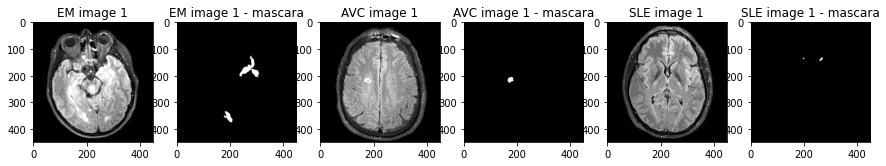

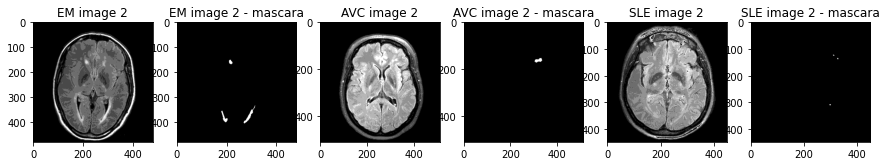

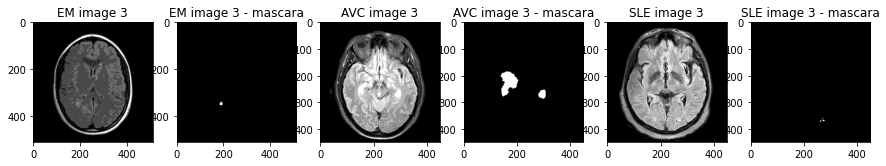

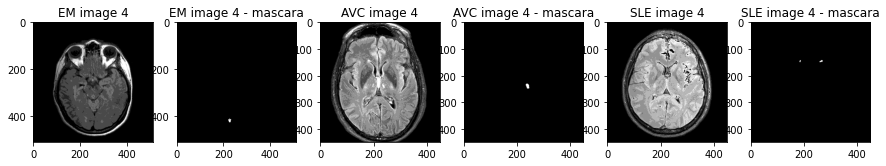

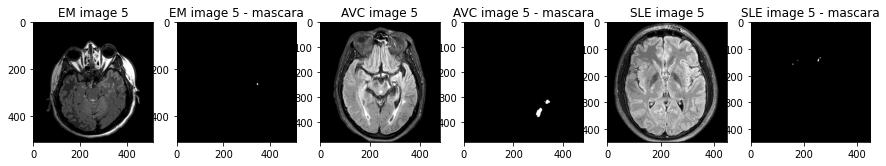

In [ ]:
figure = plt.figure(figsize=(15,15))
figure.add_subplot(1,6,1)
plt.title("EM image 1")
plt.imshow(data_em[2][1][1], cmap='gray')
figure.add_subplot(1,6,2)
plt.title("EM image 1 - mascara")
plt.imshow(data_em[2][1][0], cmap='gray')
figure.add_subplot(1,6,3)
plt.title("AVC image 1")
plt.imshow(data_avc[1][1][1], cmap='gray')
figure.add_subplot(1,6,4)
plt.title("AVC image 1 - mascara")
plt.imshow(data_avc[1][1][0], cmap='gray')
figure.add_subplot(1,6,5)
plt.title("SLE image 1")
plt.imshow(data_sle[1][1][1], cmap='gray')
figure.add_subplot(1,6,6)
plt.title("SLE image 1 - mascara")
plt.imshow(data_sle[1][1][0], cmap='gray')


figure = plt.figure(figsize=(15,15))
figure.add_subplot(1,6,1)
plt.title("EM image 2")
plt.imshow(data_em[3][1][1], cmap='gray')
figure.add_subplot(1,6,2)
plt.title("EM image 2 - mascara")
plt.imshow(data_em[3][1][0], cmap='gray')
figure.add_subplot(1,6,3)
plt.title("AVC image 2")
plt.imshow(data_avc[3][1][1], cmap='gray')
figure.add_subplot(1,6,4)
plt.title("AVC image 2 - mascara")
plt.imshow(data_avc[3][1][0], cmap='gray')
figure.add_subplot(1,6,5)
plt.title("SLE image 2")
plt.imshow(data_sle[2][1][1], cmap='gray')
figure.add_subplot(1,6,6)
plt.title("SLE image 2 - mascara")
plt.imshow(data_sle[2][1][0], cmap='gray')


figure = plt.figure(figsize=(15,15))
figure.add_subplot(1,6,1)
plt.title("EM image 3")
plt.imshow(data_em[4][1][1], cmap='gray')
figure.add_subplot(1,6,2)
plt.title("EM image 3 - mascara")
plt.imshow(data_em[4][1][0], cmap='gray')
figure.add_subplot(1,6,3)
plt.title("AVC image 3")
plt.imshow(data_avc[4][1][1], cmap='gray')
figure.add_subplot(1,6,4)
plt.title("AVC image 3 - mascara")
plt.imshow(data_avc[4][1][0], cmap='gray')
figure.add_subplot(1,6,5)
plt.title("SLE image 3")
plt.imshow(data_sle[3][1][1], cmap='gray')
figure.add_subplot(1,6,6)
plt.title("SLE image 3 - mascara")
plt.imshow(data_sle[3][1][0], cmap='gray')


figure = plt.figure(figsize=(15,15))
figure.add_subplot(1,6,1)
plt.title("EM image 4")
plt.imshow(data_em[7][1][1], cmap='gray')
figure.add_subplot(1,6,2)
plt.title("EM image 4 - mascara")
plt.imshow(data_em[7][1][0], cmap='gray')
figure.add_subplot(1,6,3)
plt.title("AVC image 4")
plt.imshow(data_avc[7][1][1], cmap='gray')
figure.add_subplot(1,6,4)
plt.title("AVC image 4 - mascara")
plt.imshow(data_avc[7][1][0], cmap='gray')
figure.add_subplot(1,6,5)
plt.title("SLE image 4")
plt.imshow(data_sle[4][1][1], cmap='gray')
figure.add_subplot(1,6,6)
plt.title("SLE image 4 - mascara")
plt.imshow(data_sle[4][1][0], cmap='gray')


figure = plt.figure(figsize=(15,15))
figure.add_subplot(1,6,1)
plt.title("EM image 5")
plt.imshow(data_em[8][1][1], cmap='gray')
figure.add_subplot(1,6,2)
plt.title("EM image 5 - mascara")
plt.imshow(data_em[8][1][0], cmap='gray')
figure.add_subplot(1,6,3)
plt.title("AVC image 5")
plt.imshow(data_avc[6][1][1], cmap='gray')
figure.add_subplot(1,6,4)
plt.title("AVC image 5 - mascara")
plt.imshow(data_avc[6][1][0], cmap='gray')
figure.add_subplot(1,6,5)
plt.title("SLE image 5")
plt.imshow(data_sle[5][1][1], cmap='gray')
figure.add_subplot(1,6,6)
plt.title("SLE image 5 - mascara")
plt.imshow(data_sle[5][1][0], cmap='gray')

## Análise visual de imagens classificadas erradas

Para imagem de EM classificadas AVC EM


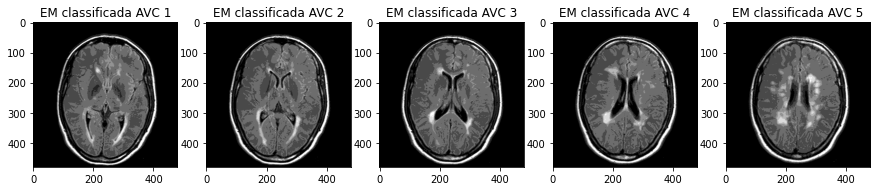

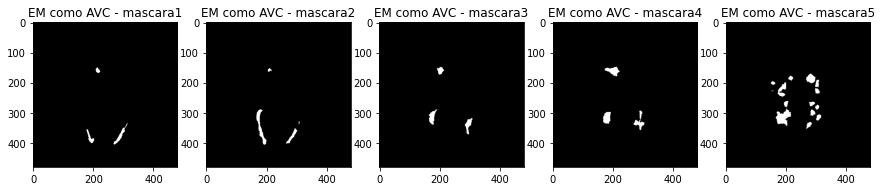

In [ ]:
print("Para imagem de EM classificadas AVC EM")
if len(em_as_avc_index) == 0:
  print("Nenhuma imagem de EM foi classificada como AVC")
else:
  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(em_as_avc_index):
    len_figure = 5
    if len(em_as_avc_index) < 5:
      len_figure = len(em_as_avc_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("EM classificada AVC " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][1], cmap='gray')
    if list_index >= 4:
      break

  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(em_as_avc_index):
    len_figure = 5
    if len(em_as_avc_index) < 5:
      len_figure = len(em_as_avc_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("EM como AVC - mascara " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][0], cmap='gray')
    if list_index >= 4:
      break



In [ ]:

print("\n\nPara imagem de EM classificadas como SLE")
if len(em_as_sle_index) == 0:
  print("Nenhuma imagem de EM foi classificada como SLE")
else:
  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(em_as_sle_index):
    len_figure = 5
    if len(em_as_sle_index) < 5:
      len_figure = len(em_as_sle_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("EM classificada SLE " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][1], cmap='gray')
    if list_index >= 4:
      break

  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(em_as_sle_index):
    len_figure = 5
    if len(em_as_sle_index) < 5:
      len_figure = len(em_as_sle_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("EM como SLE - máscara " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][0], cmap='gray')
    if list_index >= 4:
      break



Para imagem de EM classificadas como SLE
Nenhuma imagem de EM foi classificada como SLE


In [ ]:
print("\n\nPara imagem de AVC classificadas como EM")
if len(avc_as_em_index) == 0:
  print("Nenhuma imagem de AVC foi classificada como EM")
else:
  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(avc_as_em_index):
    len_figure = 5
    if len(avc_as_em_index) < 5:
      len_figure = len(avc_as_em_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("AVC classificada EM " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][1], cmap='gray')
    if list_index >= 4:
      break

  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(avc_as_em_index):
    len_figure = 5
    if len(avc_as_em_index) < 5:
      len_figure = len(avc_as_em_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("AVC como EM - máscara " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][0], cmap='gray')
    if list_index >= 4:
      break



Para imagem de AVC classificadas como EM
Nenhuma imagem de AVC foi classificada como EM




Para imagem de AVC classificadas como SLE


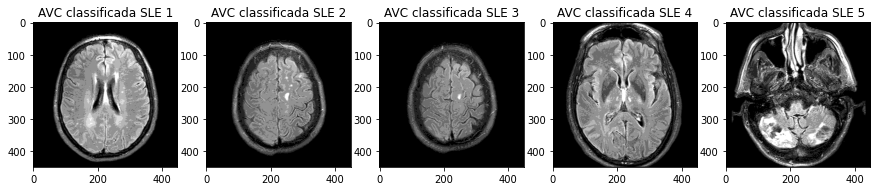

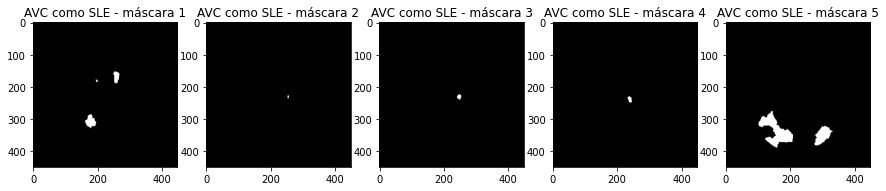

In [ ]:

print("\n\nPara imagem de AVC classificadas como SLE")
if len(avc_as_sle_index) == 0:
  print("Nenhuma imagem de AVC foi classificada como SLE")
else:
  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(avc_as_sle_index[2:]):
    len_figure = 5
    if len(avc_as_sle_index) < 5:
      len_figure = len(avc_as_sle_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("AVC classificada SLE " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][1], cmap='gray')
    if list_index >= 4:
      break

  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(avc_as_sle_index[2:]):
    len_figure = 5
    if len(avc_as_sle_index) < 5:
      len_figure = len(avc_as_sle_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("AVC como SLE - máscara " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][0], cmap='gray')
    if list_index >= 4:
      break



Para imagem de SLE classificadas como AVC


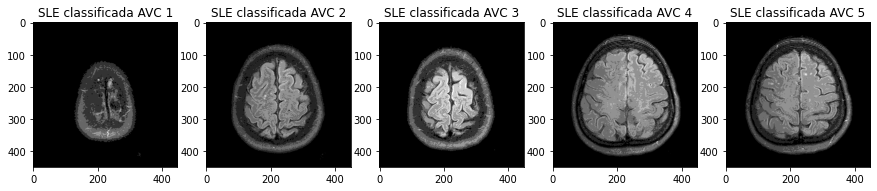

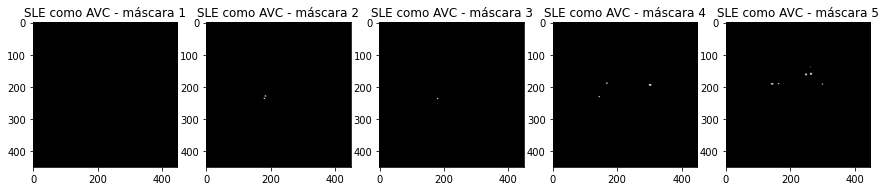

In [ ]:
print("\n\nPara imagem de SLE classificadas como AVC")
if len(sle_as_avc_index) == 0:
  print("Nenhuma imagem de SLE foi classificada como AVC")
else:
  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(sle_as_avc_index):
    len_figure = 5
    if len(sle_as_avc_index) < 5:
      len_figure = len(sle_as_avc_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("SLE classificada AVC " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][1], cmap='gray')
    if list_index >= 4:
      break

  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(sle_as_avc_index):
    len_figure = 5
    if len(sle_as_avc_index) < 5:
      len_figure = len(sle_as_avc_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("SLE como AVC - máscara " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][0], cmap='gray')
    if list_index >= 4:
      break

In [ ]:
print("\n\nPara imagem de SLE classificadas como EM")
if len(sle_as_em_index) == 0:
  print("Nenhuma imagem de SLE foi classificada como EM")
else:
  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(sle_as_em_index):
    len_figure = 5
    if len(sle_as_em_index) < 5:
      len_figure = len(sle_as_em_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("SLE classificada EM " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][1], cmap='gray')
    if list_index >= 4:
      break

  figure = plt.figure(figsize=(15,15))
  for list_index, fig_index in enumerate(sle_as_em_index):
    len_figure = 5
    if len(sle_as_em_index) < 5:
      len_figure = len(sle_as_em_index)
    figure.add_subplot(1,len_figure,list_index + 1)
    plt.title("SLE como EM - máscara " + str(list_index + 1))
    plt.imshow(validation_data[fig_index][0], cmap='gray')
    if list_index >= 4:
      break



Para imagem de SLE classificadas como EM
Nenhuma imagem de SLE foi classificada como EM


# Resultados Obtidos e Discussão
## Resultados quantitativos
<p> No nosso modelo apresentado para classificação de lesões neuronais de lúpus treinados para diferenciar as lesões de AVC e EM, obtivemos 98% de acurácia e 97% de precisão. Quando avaliado para o grupo teste, obtivemos um resultado de 99% de acurácia na nossa classificação - valor informado pela prof. Letícia após a avaliação do teste .</p>
<p> Na primeira análise das imagens testes de lúpus – SLE, nosso modelo, utilizando-se de alguns atributos como de textura (SRE, LRE, GLU, RPC, RLU), de histograma (skewness, curtose) e de descritores estatísticos (maior valor da imagem, desvio padrão da imagem, contador de pixels não zerados), conseguiu diferenciar as etiologias das lesões como AVC para 686 das imagens (98,42%) e 11 como EM (1,57% imagens).  </p>
<p>Após a análise dos atributos utilizados para melhor diferenciação etiológica, verificamos que as mais indicadas para esta discriminação seriam: </p>


*   AVC: LRE, GLU, RPC e desvio padrão das imagens;  
*   EM: - Máximo valor da imagem. 



<p>Deste modo, a segunda análise realizada das imagens SLE foram utilizando unicamente os atributos para AVC. Neste, a classificação resultou em 697 imagens sendo semelhantes a AVC (100%) e nenhuma foi separada como EM.  </p>
<p>Verificamos, nas nossas análises, que os atributos mais importantes para a classificação das imagens de ressonância etiologicamente semelhante ao AVC foram os que avaliavam as texturas grossas – presentes nas grandes corridas das matrizes de comprimento de corrida; a uniformidade da variação de cinza da imagem; a homogeneidade referente ao histograma; e o desvio padrão dos pixels existentes na imagem.  </p>
<p>Por fim, geramos um modelo com intuito de predizer os três casos – AVC, EM e SLE. Para este novo modelo, a acurácia obtida foi de 90,41% e sua precisão de 90,88%. A classificação utilizou descritores para a tomada da decisão, sendo estes: LRE, GLU, RLU, GLCM, valor máximo, média, variância, skewness, curtose de Fisher e de Pearson, desvio padrão, soma dos pixels e valor máximo, média e desvio padrão da imagem. Na avaliação da quantidade de casos separados por cada etiologia, verificamos que em alguns casos, o novo modelo classificou erroneamente. Das 532 imagens de ressonância utilizadas na validação do modelo, 35 imagens de AVC foram reconhecidas como SLE, 9 imagens de EM foram entendidas como AVC e 7 de SLE foram apontadas como AVC. </p>


## Resultados qualitativos

Na análise qualitativas das imagens de ressonância, observamos 15 imagens, sendo divididas entre AVC, EM e SLE, iqualmente. Para cada grupo de figuras avaliamos a graduação de cinza, o formato e dimensão das lesões, a localização, a quantidade, a simetria entre outros.

No grupo de EM verificamos que a instensidade da graduação de cinza era menor quando comparado com os outros agrupamentos (AVC e SLE), bem perceptível ao observarmos a diferença de coloração entre as massas branca dos diferentes grupos. Fato que, poderia ter sido ajustado com normalização das imagens. Contudo, foi constatado que quando era realizada havia a diminuição das métricas do modelo. Além disso, em virtude do contraste mais escuro da substância branca, as lesões possuem pixels com valores maiores, sendo estes mais destoantes, com sua hiperintensidade mais fácil de visualização.

As imagems de lesões desmielizantes também aparenta ter lesões que mantém o padrão de localização na região dos ventrículos laterais nas porção tanto posterior quanto anterior. Como também, limitando-se a região da massa branca que é a local onde se apresenta a mielina, capa de gordura que envolve os axônios. Além do mais, são lesões mais lineares e não é visível a grande difusão da extensão das lesões para outras regiões do cérebro.

Ao analisarmos o conjunto com AVC, foi observado que o contraste da imagem era semelhante ao visualizado nas imagens SLE. Além disso, os pixels de intensidade das lesões estavam aparentemente próximos. Esta similaridade na intensidade das imagens dos diferentes agrupamentos pode ter causado um viés importante neste modelo apresentado. Hipotetisamos que a diferenciação pode ter sido realizada utilizando-se da intensidade das imagens e não da diferenças das lesões. A aplicação de normalização e de limpeza de pixels que não fazem parte da máscara deveriam auxiliar na diminuição do enviesamento da classificação, contudo pelas baixas métricas nos resultados não utilizamos no nosso modelo.

Outro ponto observado, foi que as lesões provenientes de isquémia, não apresentavam localização padronizada, podendo ocorrer em diferentes regiões da substância branca e se distender até o córtex cerebral. Deste modo, muitas imagens demostravam lesões maiores quando comparava com as demais.

As lesões das figuras de SLE eram visualmente menores, com uma certa simetria entre os ventrículos direito e esquerdo. Não aparentavam ser lesões difundas, contudo eram disseminadas, com mais de um ponto de hiperintesidade em diferentes regiões cerebrais. Sua localização não aparentava padrão, mas estava exclusivamente na região branca do cérebro.

No segundo modelo apresentado, criado com EM, AVC e SLE, avaliamos que pode ter havido uma diminuição no enviesamento da classificação dos dados. Nossa hipótese é que com a introdução do novo grupo (SLE) no aprendizado, houve o aperfeiçoamento dos descritores. Deste modo, mesmo com métricas menor que o modelo anterior, cremos que a sua separação por diferença de intensidade é reduzida. Mesmo tendo a diminuição do viés, o grande número de imagens de AVC entendida como SLE pode está ainda relacionada a semelhança dos contrastes.


# Conclusão

Podemos concluir que o processo de trabalho nos dados para a criação do modelo de Machine learning é um fator preponderante para seu sucesso, desde o tratamento dos dados originais, até o processo de seleção dos descritores para obtenção dos dados entregues ao algoritmo.

Em termos quantitativos, os resulados obtidos apresentaram acurácia, recall, F1 score, precisão superiores à 97% para o modelo usando AVC e EM, e superiores à 89% para o modelo usando AVC, EM e SLE. Contudo, na análise qualitativa, a classificação dos dados pode ter sido enviezada pela graduação da intensidade de cinza das imagens.


Concluímos-se assim que as imagens de ressoância de lesão neuronal de lúpus assemelham-se, etiologicamente, as lesões isquêmicas de AVC. Nas nossas primeira análise, o modelo classificou como AVC a grande maioria das imagens (>98%). Na segunda análise relizada com a filtragens dos descritores, o modelo conseguiu agrupar todas as imagens como AVC. Em relação ao modelo com as três etiologias, algumas figuras foram rotuladas erroneamente. Isto ocorreu principalmente entre as imagens de lesões de AVC e de SLE, o que demostra que critérios usados para classificação de AVC podem ser usados para SLE.



## Dificuldades do projeto

O nível do projeto foi elevado, sendo as maiores dificuldades observados pelo grupo foram: 

* Análisar diferentes kernels, aplicação de ROI, zerar pixels que não estão na máscara, testar técnicas de normalização ou o uso da imagem original e verificar o resultado obtido para os dados de validação para cada cenário, procurando aquele com melhor acurácia;
* Ajustar os descritores: quais usar? quais não usar? Muitas análises foram feitas para essa definição;
* Com o uso da imagem inteira, o tempo de processamento requerido pelo colab aumentou bastante, e mesmo com adaptações para a etapa demorada precisar rodar apenas uma vez, isso impactou na flexibilidade para testar e editar o código. 
* Análisar o label para ter certeza que está coerente. 


## Trabalhos Futuros:
Para trabalhos futuros algumas coisas que poderiam ser feitas são:
* Adicionar novos descritores relacionados aos pixels da imagem.
* Fazer análise de viéses do resultado.
* Utilizar ressonâncias originadas de outras máquinas e assim diminuir possível overfitting ou eviesamento.
* Repetir experimento utilizando redes neurais e comparar os resultados.
* Análisar os atributos gerando uma tabela de corelação entre eles, eliminando componentes desnecessárias.
* Criar modelo usando técnicas mais robustas de cross-validation, como o K-fold.
* Fazer uma análise mais profunda sobre o enviesamento do código e quanto a normalização, a ROI e o ignorar dos pixel fora da máscara podem ajudar.


# Referências Bibliográficas
* **3.1. Cross-validation: evaluating estimator performance.** Disponível em: <https://scikit-learn/stable/modules/cross_validation.html>. Acesso em: 7 jul. 2022. 

* NAIR, A. **Understanding The Basics Of SVM With Example And Python Implementation.** Disponível em: <https://analyticsindiamag.com/understanding-the-basics-of-svm-with-example-and-python-implementation/>. Acesso em: 7 jul. 2022. 

* **Tutorial: image classification with scikit-learn.** Kapernikov, 10 abr. 2018. Disponível em: <https://kapernikov.com/tutorial-image-classification-with-scikit-learn/>. Acesso em: 7 jul. 2022
